In [78]:
import pandas as pd
import numpy as np
import matplotlib as plt

#logs = pd.read_csv("anonimized_logs.csv")
courses = pd.read_csv("anonimized_courses.csv")
registrations = pd.read_csv("anonimized_registrations.csv")
users = pd.read_csv("anonimized_users.csv")
tasks = pd.read_csv("anonimized_tasks.csv")
#sections = pd.read_csv("anonimized_sections.csv")
#sec_harness = pd.read_csv("anonimized_section_harnessing_task.csv")

In [79]:
#tipo de registro
registrations.currentState.unique()

array(['IN_PROGRESS', 'NOT_VISIBLE', 'PAUSED', 'BOOKMARKED'], dtype=object)

In [80]:
#Estimando porcentagem medias de conclusão de cursos pelos alunos

#Removendo Cursos não iniciados
rg=registrations[registrations.currentState!='BOOKMARKED']
rg=rg[rg.currentState!='NOT_VISIBLE']
rg.currentState.unique()

array(['IN_PROGRESS', 'PAUSED'], dtype=object)

In [81]:
#Dividindo em alunos que finalizaram o curso, em progresso, e não finalizaram
#Considerando que cursos acessados pelo aluno em 2 meses estão em progresso
maxTime=np.timedelta64(2, 'M')
rg.loc[pd.to_datetime(rg['lastAccessDate'])<pd.Timestamp('2020-08-27 23:59:00.000000')-maxTime,'status']='unfinished'
rg.loc[pd.to_datetime(rg['lastAccessDate'])>=pd.Timestamp('2020-08-27 23:59:00.000000')-maxTime,'status']='attending'
rg.loc[rg['finishedAt'].notnull(),'status']='finished'

#To do
#Definir um melhor modo para classificar entre cursos finalizados, em progresso e não finalizados
#Ex: Cursos que foram abandonados mas 90% completados poderiam ser considerados como acabados
#    e não deveriam ter o mesmo peso que cursos 30% completados
#
#Ex2: Cursos 1% completos poderiam ser considerados como não começados, já que talvez
#     o aluno estava apenas checando se o assunto é de seu interesse

#     Tentei definir a porcentagem do curso que foi completa com relaçaõ a quantidade de tasks feitas
#     porém cada dupla (aluno, curso) parece só ter uma task

status
attending      32787
finished      275435
unfinished    392163
Name: status, dtype: int64

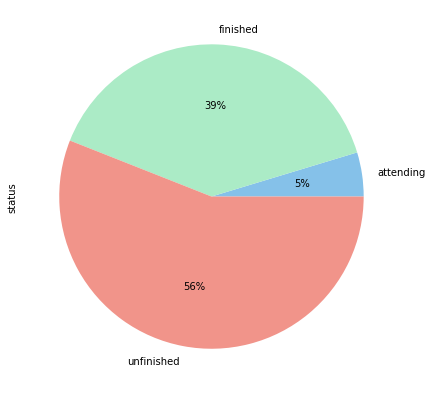

In [82]:
#Porcentagem media de cursos terminados, abandonados e em progresso
rg.groupby('status')['status'].count().plot.pie(colors = ['#85c1e9','#abebc6','#f1948a'], autopct='%1.0f%%',figsize=(7, 7))
rg.groupby('status')['status'].count()

In [83]:
# Contando a quantidade de alunos por cursos
studentsCount = rg.groupby('course_uuid')['status'].count()
studentsCount = studentsCount.to_frame()
studentsCount = studentsCount.reset_index()
studentsCount = studentsCount.rename(columns={'status': 'studentsCount'})
studentsCount.head()

,course_uuid,studentsCount
0,1,1029
1,2,11
2,4,805
3,5,260
4,6,89


In [84]:
#Taxa de conclusão por curso
statusByCourse = rg.groupby('course_uuid')['status'].value_counts(normalize=True)*100
statusByCourse = statusByCourse.drop(labels='unfinished',level=1)
statusByCourse = statusByCourse.drop(labels='attending',level=1)
statusByCourse = statusByCourse.reset_index(level=1,drop=True)
statusByCourse = statusByCourse.to_frame()
statusByCourse = statusByCourse.rename(columns={'status': 'completionRate'})
statusByCourse = statusByCourse.reset_index()
statusByCourse.head()

,course_uuid,completionRate
0,1,31.972789
1,2,27.272727
2,4,20.496894
3,5,28.846154
4,6,43.820225


In [85]:
#Juntando dados dos cursos com suas respectivas taxas de conclusão e numero de alunos
cs = courses

cs = cs.merge(statusByCourse,left_on='uuid', right_on='course_uuid', how='left')
cs = cs.merge(studentsCount,left_on='uuid', right_on='course_uuid', how='left')
cs = cs[cs['completionRate'].notna()]
cs.head()

,createdAt,level,publicatedAt,totalVideoTime,subCategory_id,situation,isProject,removedAt,uuid,substitute_uuid,course_uuid_x,completionRate,course_uuid_y,studentsCount
0,2011-09-22,1,2011-09-22,51,30,PUBLISHED,0,NaN,588,NaN,588.0,21.828255,588.0,1805.0
1,2011-10-27,5,2011-10-27,72,21,PUBLISHED,0,NaN,840,NaN,840.0,19.545803,840.0,7838.0
2,2012-02-15,1,2012-02-15,112,1,PUBLISHED,0,NaN,764,NaN,764.0,27.505938,764.0,4210.0
3,2012-03-07,5,2012-03-07,83,21,PUBLISHED,0,NaN,720,NaN,720.0,28.499528,720.0,3179.0
5,2012-04-27,1,2012-04-27,51,12,PUBLISHED,0,NaN,828,NaN,828.0,29.170306,828.0,1145.0


In [86]:
cs['completionRate'].describe()

count    838.000000
mean      34.515910
std       13.799379
min        4.000000
25%       24.315026
50%       33.147681
75%       43.558113
max       79.175758
Name: completionRate, dtype: float64

In [87]:
cs['studentsCount'].describe()

count      838.000000
mean       835.717184
std       1314.988638
min          5.000000
25%        108.000000
50%        345.000000
75%        940.750000
max      15634.000000
Name: studentsCount, dtype: float64

In [88]:
#Taxa de conclusão e numero de alunos por level (1, 5 ou 10)
level = cs[['level','completionRate','studentsCount']]
level = level.groupby('level')
level.describe()

completionRate                                                        \
               count       mean        std       min        25%        50%   
level                                                                        
1              519.0  35.340739  14.346336  4.000000  24.501123  33.333333   
5              281.0  33.683748  12.900759  7.142857  24.305556  33.000000   
10              38.0  29.404100  11.185889  5.555556  21.678980  30.851107   

                            studentsCount                                 \
             75%        max         count        mean          std   min   
level                                                                      
1      44.032025  79.175758         519.0  868.695568  1376.089248   6.0   
5      43.256997  65.295630         281.0  805.145907  1257.060294   5.0   
10     37.392906  50.943396          38.0  611.368421   757.742894  18.0   

                                        
          25%    50%      75%      max  
level                                   
1      127.50  382.0   967.00  15634.0  
5       97.00  259.0   928.00   8066.0  
10      71.25  247.0  1000.25   3227.0

In [89]:
levelCompletion = level['completionRate'].mean().to_frame()
levelCompletion = levelCompletion.reset_index()
levelCompletion.head()

,level,completionRate
0,1,35.340739
1,5,33.683748
2,10,29.404100
